# Transfer-Learning , Scaled Up models 

### Beating 50.76% Accuracy , accross all classes 
#### Mini Models : 101 classes of data with 10% input 


In [48]:
import tensorflow as tf
import keras
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("CUDA Support:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.config.list_physical_devices('GPU'))


CUDA Support: True
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### Import Helper Functions 

In [1]:
from helper import *

2025-03-11 11:55:17.270291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741690517.338685  270767 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741690517.359188  270767 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-11 11:55:17.508101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 101 Classes of data 
train_dir = "101_food_classes_10_percent/101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/101_food_classes_10_percent/test"

In [3]:
walk_through_dir("/home/akhil/Documents/Tf_Local/101_food_classes_10_percent")

There are 2 directories and 0 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent'.
There are 1 directories and 1 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/__MACOSX'.
There are 1 directories and 2 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/__MACOSX/101_food_classes_10_percent'.
There are 0 directories and 34 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/__MACOSX/101_food_classes_10_percent/test'.
There are 2 directories and 0 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '/home/akhil/Documents/Tf_Local/101_food_classes_10

In [4]:
# Set up data input

import tensorflow as tf
import tf_keras
IMG_SIZE = (224 ,224)
train_data_all_10_percent = tf_keras.preprocessing.image_dataset_from_directory(train_dir ,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)
test_data = tf_keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle = False ) # Dont Shuffle the  test daata for prediction analysis 



Found 7575 files belonging to 101 classes.


I0000 00:00:1741690521.724506  270767 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3829 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 25250 files belonging to 101 classes.


- Model Checkpoit 
- Data augmentation layer 
- Build headless fnctional efficientB0 model 
- Compile 
- Feeature Extract for 5 full passes on training data
- Validate on 15 % of Test data 



In [5]:
# Training teh transfer learning model with 10 percent of the data 

# Create Checkpoint Callback 
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf_keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only= True,
                                                         monitor= "accuracy",
                                                         save_best_only=True)

## Pushing Data Augmentaion on GPU 💷

In [6]:
# Data Augmentation Layer

from tf_keras import layers
from tf_keras.layers.experimental import preprocessing 
from tf_keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)  #Rescaling is not required in this case , but required in the resnet models
     
], name = "data_augmentation")


In [7]:
# Headless model , with Functional API 
# Baase Model , freeaze some layers

base_model = tf_keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Model Architechure with trinable top layers

inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs)  # Computed on GPU during Training phase 
x = base_model(x, training = False) # Freezed Layers 
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(101, activation = "softmax")(x)
model = tf_keras.Model(inputs, outputs)

# Compile the model

model.compile(loss = "categorical_crossentropy",
              optimizer = tf_keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit the model

history_10_percent = model.fit(train_data_all_10_percent,
                               epochs = 5,
                               steps_per_epoch = len(train_data_all_10_percent),
                               validation_data = test_data,
                               validation_steps = int(0.15 * len(test_data)),
                               callbacks = [checkpoint_callback])



Epoch 1/5


I0000 00:00:1741690534.019566  271364 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/237 [..............................] - ETA: 28:32 - loss: 4.7589 - accuracy: 0.0000e+00

I0000 00:00:1741690534.582113  271363 service.cc:148] XLA service 0x753df0b5ff00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741690534.582220  271363 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-03-11 11:55:34.590442: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741690534.680619  271363 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


237/237 [==============================] - 46s 165ms/step - loss: 3.3630 - accuracy: 0.2782 - val_loss: 2.3921 - val_accuracy: 0.4899
Epoch 2/5
237/237 [==============================] - 37s 155ms/step - loss: 2.1989 - accuracy: 0.4957 - val_loss: 1.9795 - val_accuracy: 0.5342
Epoch 3/5
237/237 [==============================] - 37s 156ms/step - loss: 1.8104 - accuracy: 0.5674 - val_loss: 1.8491 - val_accuracy: 0.5477
Epoch 4/5
237/237 [==============================] - 37s 156ms/step - loss: 1.6010 - accuracy: 0.6170 - val_loss: 1.7703 - val_accuracy: 0.5493
Epoch 5/5
237/237 [==============================] - 37s 158ms/step - loss: 1.4482 - accuracy: 0.6477 - val_loss: 1.7090 - val_accuracy: 0.5535


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [9]:
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 43s 55ms/step - loss: 1.5667 - accuracy: 0.5891


[1.566685676574707, 0.5890693068504333]

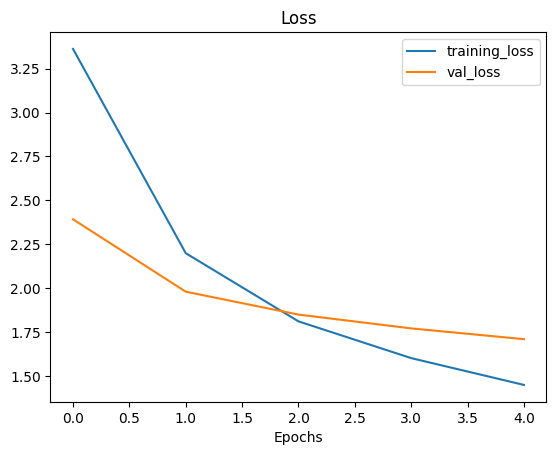

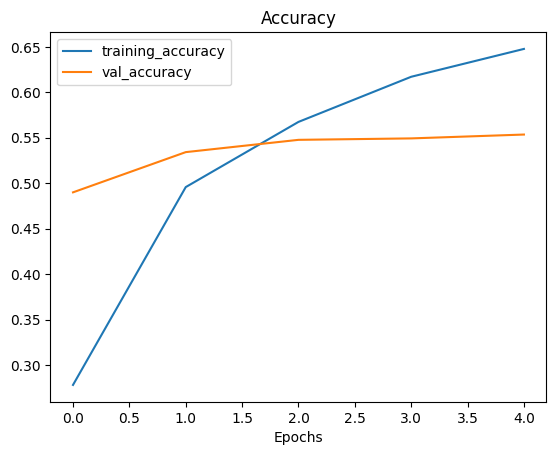

In [10]:
# Plotting loss curves 

plot_loss_curves(history_10_percent)

In [11]:
# Curves separating in the end , means model is overfitting : performing too well on training data , and not genralizing on the unseen data 

## Fine Tuning 

---
- When unfreezing a layer make the learning rate slow 
- Unfreeze all of the layers in the base_model 
- Unfreezing last 5 layers , 
- Last layers are responsible , for the larger features

In [12]:
# Unfreeze all of the layers in the base_model 
base_model.trainable = True 

# Refreeze 

for layer in base_model.layers[:-5]: # Unfrozen last 5 layerss
    layer.trainable = False

In [13]:
# Recompile , model with lower learning rate
model.compile(loss = "categorical_crossentropy",
              optimizer = tf_keras.optimizers.Adam(learning_rate = 0.0001), # learning rate lowered by 10x
              metrics = ["accuracy"])


In [14]:
# looking for the trainable layers in the model 

for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling2d True
dense True


In [15]:
# Checking for the trainable layers in the base_model 

for layer_number , layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)



# This should show that the last 5 layers should be trainable , and every other layer should be frozen

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.multiply False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fal

In [16]:
# Model Fine-Tuning : starting the training  from the epoch left behind last time 

fine_tune_epochs = 10 # model has already trained for 5 epochs , resumin from that point 
# Fine -Tune 

history_all_classes_10_percent_fine_tune = model.fit (train_data_all_10_percent,
                                                       epochs = fine_tune_epochs,
                                                       validation_data = test_data,
                                                       validation_steps = int(0.15 * len(test_data)),
                                                       initial_epoch = history_10_percent.epoch[-1])




Epoch 5/10


237/237 [==============================] - 168s 675ms/step - loss: 1.2035 - accuracy: 0.6883 - val_loss: 1.6737 - val_accuracy: 0.5564
Epoch 6/10
237/237 [==============================] - 108s 456ms/step - loss: 1.0933 - accuracy: 0.7090 - val_loss: 1.6198 - val_accuracy: 0.5673
Epoch 7/10
237/237 [==============================] - 90s 377ms/step - loss: 1.0099 - accuracy: 0.7283 - val_loss: 1.6374 - val_accuracy: 0.5683
Epoch 8/10
237/237 [==============================] - 82s 345ms/step - loss: 0.9505 - accuracy: 0.7505 - val_loss: 1.6296 - val_accuracy: 0.5620
Epoch 9/10
237/237 [==============================] - 74s 313ms/step - loss: 0.8874 - accuracy: 0.7552 - val_loss: 1.6274 - val_accuracy: 0.5681
Epoch 10/10
237/237 [==============================] - 70s 294ms/step - loss: 0.8494 - accuracy: 0.7682 - val_loss: 1.6552 - val_accuracy: 0.5583


In [17]:
# Evaluate on the full Test Data 

all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results


790/790 [==============================] - 44s 56ms/step - loss: 1.4859 - accuracy: 0.6061


[1.4858832359313965, 0.6061385869979858]

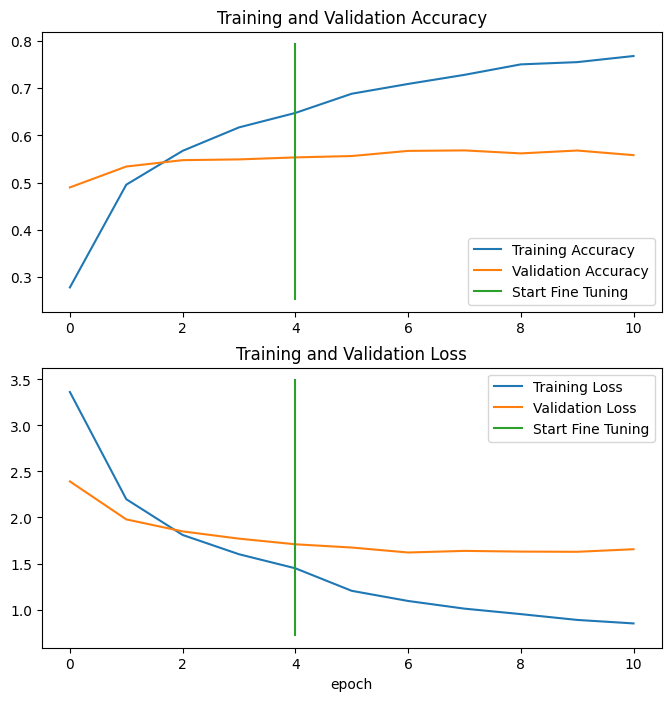

In [18]:
# Compare the histories , with feature extraction models , with fine tune models

compare_historys(original_history = history_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

In [19]:
# Saving and Loading the model 

model.save("101_classes_10_percent_saved_model")

INFO:tensorflow:Assets written to: 101_classes_10_percent_saved_model/assets


INFO:tensorflow:Assets written to: 101_classes_10_percent_saved_model/assets


In [20]:
loaded_model = tf_keras.models.load_model("101_classes_10_percent_saved_model")

In [21]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 44s 55ms/step - loss: 1.4859 - accuracy: 0.6061


[1.4858832359313965, 0.6061385869979858]

In [22]:
# Evaluating the performance of the model , accross all the different classes
# Making predictions and plotting them 

import numpy as np
from tf_keras import utils


# uSING A ALREADY BUILT FINE TUNE MODEL 

# Load the saved model

model = tf_keras.models.load_model("/home/akhil/Documents/Tf_Local/06_101_food_class_10_percent_saved_big_dog_model (2)/06_101_food_class_10_percent_saved_big_dog_model")


In [23]:
# Evaluate the loaded model ( in test data)

results_premade_model = model.evaluate(test_data)
results_premade_model

790/790 [==============================] - 45s 55ms/step - loss: 1.8022 - accuracy: 0.6078


[1.8021925687789917, 0.6078416109085083]

In [24]:
preds_probs = model.predict(test_data, verbose = 1)

790/790 [==============================] - 42s 51ms/step


In [25]:
len(test_data)

790

In [26]:
790*32

25280

In [27]:
# How many predictions are there ?

len(preds_probs)

25250

In [28]:
# What is the shape of the PRedictions ?
preds_probs.shape

(25250, 101)

In [29]:
# What are the 10 first predictions ?
preds_probs[:10]

array([[5.9386708e-02, 3.5747303e-06, 4.1280869e-02, ..., 1.4112708e-09,
        8.3762250e-05, 3.0842533e-03],
       [9.6350169e-01, 1.3720646e-09, 8.4753177e-04, ..., 5.4724285e-05,
        7.8266577e-12, 9.7968811e-10],
       [9.5956594e-01, 3.2370048e-05, 1.4756998e-03, ..., 7.1490882e-07,
        5.4971537e-07, 4.0044932e-05],
       ...,
       [4.7309124e-01, 1.2900098e-07, 1.4718017e-03, ..., 5.9502193e-04,
        6.7334659e-05, 2.3502811e-05],
       [4.4531006e-02, 4.7604877e-07, 1.2223568e-01, ..., 6.3220350e-06,
        7.5684193e-06, 3.6753835e-03],
       [7.2422320e-01, 1.9260369e-09, 5.2292740e-05, ..., 1.2220119e-03,
        1.5770126e-09, 9.6254575e-05]], dtype=float32)

In [30]:
# Shape of the arraat of the first prediction 
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9386708e-02, 3.5747303e-06, 4.1280869e-02, 1.0592210e-09,
        8.1656948e-09, 8.5725880e-09, 8.0980789e-07, 8.4500476e-07,
        1.9760229e-05, 7.9796638e-07, 3.1705121e-09, 9.7980217e-07,
        2.8393482e-04, 7.7416706e-10, 7.3978468e-04, 3.8668364e-05,
        6.4538913e-06, 2.4955355e-06, 3.7628870e-05, 2.0478858e-07,
        1.5546590e-05, 8.0694463e-07, 2.6047994e-06, 2.0285646e-07,
        8.2894064e-07, 5.4123880e-06, 3.7363448e-06, 1.3161273e-08,
        2.7436682e-03, 2.7954495e-05, 6.8107542e-10, 2.5341104e-05,
        1.6642838e-04, 7.5475942e-10, 4.0284812e-04, 1.3077920e-08,
        1.7873915e-06, 1.4374262e-06, 2.3150882e-02, 8.2202712e-07,
        8.5741175e-07, 1.6920036e-06, 7.0452434e-06, 1.8502085e-08,
        2.8571301e-07, 7.9483316e-06, 2.0710429e-06, 1.8579009e-07,
        3.3334356e-08, 3.1635989e-04, 1.0483816e-05, 8.5382464e-07,
        8.4773231e-01, 1.0542810e-05, 4.3458138e-07, 3.7250396e-05,
        3.5064731e-05, 3.2475069e-05, 6.7055254e

## Model Description 

The model outputs the prediction probability array (with) N number of variables , where N is the number of classes , for each sample , passed to the prediction model.

In [31]:
# We get one prediction probability per class , in 101 classes dataset 
print(f"Number of the prediction probability samples for 0 th sample : {len(preds_probs[0])}")
print(f"Sum of the prediction probability samples for 0 th sample : {sum(preds_probs[0])}")
print(f"Max of the prediction probability samples for 0 th sample : {np.max(preds_probs[0])}")
print(f"Index of the max prediction probability sample for 0 th sample : {np.argmax(preds_probs[0])}")



Number of the prediction probability samples for 0 th sample : 101
Sum of the prediction probability samples for 0 th sample : 1.000000238418579
Max of the prediction probability samples for 0 th sample : 0.8477323055267334
Index of the max prediction probability sample for 0 th sample : 52


In [32]:
test_data.class_names[52]

'gyoza'

In [33]:
# Get pred classes of each label 

pred_classes = preds_probs.argmax(axis = 1)

# What are the predicted classes for the first 10 samples ?
pred_classes[:10]
len(pred_classes)

25250

To Evaluate the model predictions we need ot compare the labels


In [34]:
# TO get the test labels , the test_data BatchDataset has ot be unbatched
y_labels = []
for images , labels in test_data.unbatch().as_numpy_iterator():
    y_labels.append(labels.argmax())

2025-03-11 12:13:12.864318: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

### Checking if the model's prediction array is in the same order as in the test data

In [36]:
results_premade_model

[1.8021925687789917, 0.6078416109085083]

### Trying the Scikit- Learn Accuracy Score

In [37]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6078415841584158

### Does this metric come close to our model's evaluate results 

 

In [38]:
np.isclose(results_premade_model[1], sklearn_accuracy)

np.True_

## Making a confusion matrix for all the food data 

In [39]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (50,50),
                      text_size = 10)

## Continuing the Evaluation 

- using the function from scikit-learn , precision , recall and f1
- As the f1 is the combination of precision and recall , plotting the recall for the classes



In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes, target_names = class_names))

                         precision    recall  f1-score   support

              apple_pie       0.29      0.20      0.24       250
         baby_back_ribs       0.51      0.69      0.59       250
                baklava       0.56      0.65      0.60       250
         beef_carpaccio       0.74      0.53      0.62       250
           beef_tartare       0.73      0.44      0.55       250
             beet_salad       0.34      0.54      0.42       250
               beignets       0.67      0.79      0.72       250
               bibimbap       0.82      0.76      0.79       250
          bread_pudding       0.40      0.37      0.39       250
      breakfast_burrito       0.62      0.44      0.51       250
             bruschetta       0.62      0.42      0.50       250
           caesar_salad       0.83      0.48      0.61       250
                cannoli       0.52      0.74      0.61       250
          caprese_salad       0.56      0.60      0.58       250
            carrot_cake 

In [41]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713755,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7315436241610739,
  'recall': 0.436,
  'f1-score': 0.5463659147869674,
  'support': 250.0},
 '5': {'precision': 0.3426395939086294,
  'recall': 0.54,
  'f1-score': 0.4192546583850932,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'supp

In [42]:
classification_report_dict["99"]["f1-score"]

0.35356200527704484

In [43]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713755,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.5463659147869674,
 'beet_salad': 0.4192546583850932,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.503562945368171,
 'caesar_salad': 0.6126582278481013,
 'cannoli': 0.6135986733001658,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.5736434108527132,
 'ceviche': 0.3674418604651163,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.426890756302521,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45325779036827196,
 'chocolate_mousse': 0.32857142857142857,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee

In [44]:
# tURN f1 SCORES INTO DATAFRAMES , FOR VISUALIZATION

import pandas as pd 

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),"f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending = False)
f1_scores

class_names  f1-score
33              edamame  0.935361
63             macarons  0.895397
75                  pho  0.869903
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.335196
22     chocolate_mousse  0.328571
77            pork_chop  0.308756
39            foie_gras  0.298025
0             apple_pie  0.240566

[101 rows x 2 columns]

/tmp/ipykernel_270767/3758151624.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  scores = sns.barplot(x = "f1-score", y = "class_names", data = f1_scores, palette = "viridis")


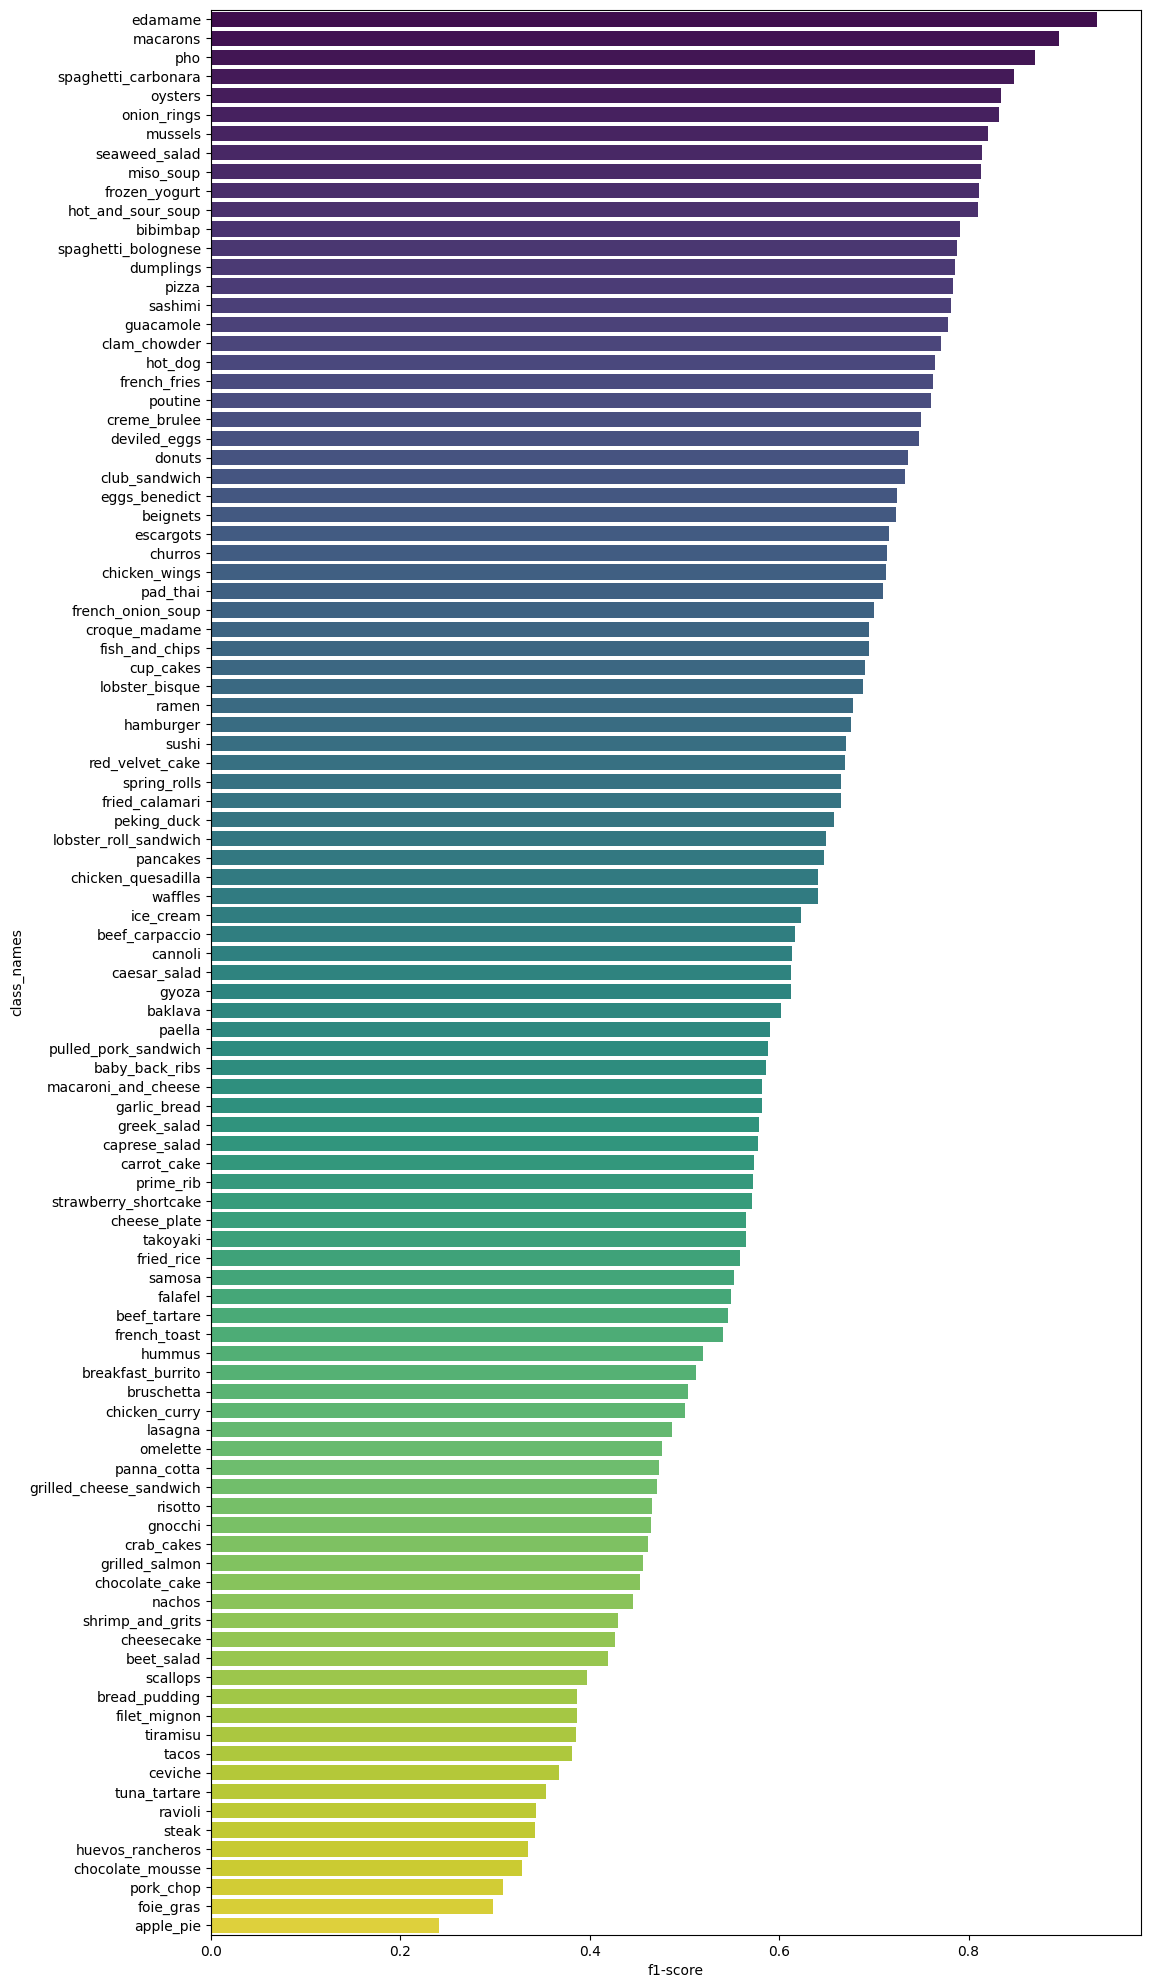

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
fig , ax = plt.subplots(figsize = (12,25))
scores = sns.barplot(x = "f1-score", y = "class_names", data = f1_scores, palette = "viridis")

In [46]:
## Visualising predictions on custom Images 

# Images are not in the test data 

# Function to load and preprocess the Loaded images 
# - Read File , from File path 
# - Turn the image into a Tensor
# - Resize the image Tensor to the same zize the model is trained on 
# - Scale the image to get the pixel values between 0 and 1 


def load_and_prep_image(filename, img_shape=224 , scale= True):
    """ Reads in an image from filename , turns it into a tensor and reshapes into a specified shape (224,224)
    Args:
    filename : str : file path to the image
    img_shape : int : size of the image shape
    scale : bool : whether to scale the pixel values or not 
    Returns :
    a preprocessed image tensor
    """
    # Read in the target image 
    img = tf.io.read_file(filename)
    # Decode the read file into a tensor
    img = tf.io.decode_image(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, size = [img_shape, img_shape])
    # Scale the image
    if scale:
        img = img/255.
    return img



# PNG and JPEG have 4 channels , RGB and Alpha ,  need to remove the alpha channel

(224, 224, 3)
1/1 [==============================] - 1s 1s/step
oysters
tf.Tensor(0.99969506, shape=(), dtype=float32)
(224, 224, 3)
1/1 [==============================] - 0s 25ms/step
chicken_quesadilla
tf.Tensor(0.45184758, shape=(), dtype=float32)
(224, 224, 3)
1/1 [==============================] - 0s 26ms/step
spaghetti_bolognese
tf.Tensor(0.96780026, shape=(), dtype=float32)


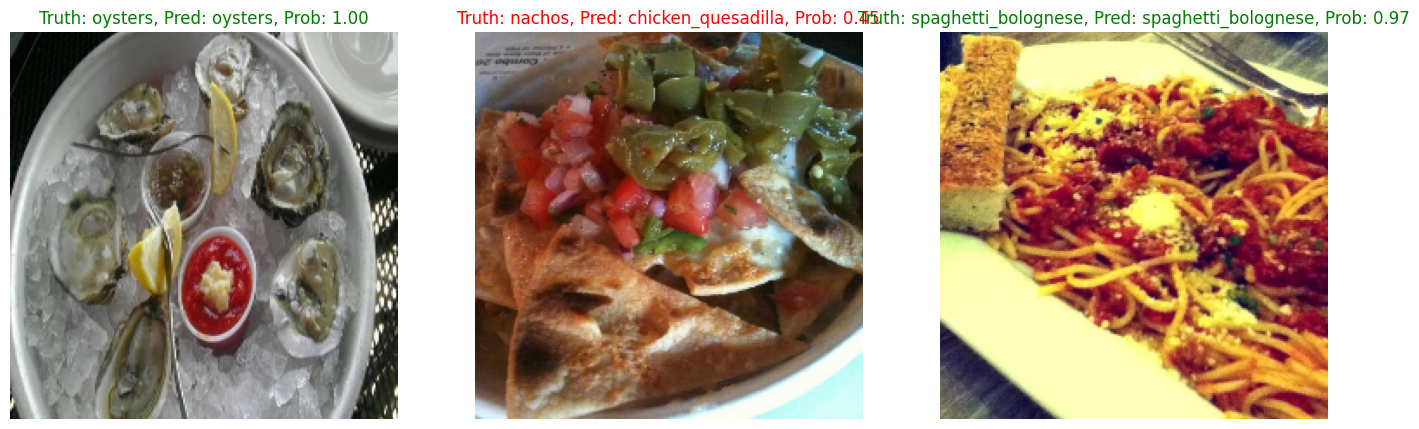

In [47]:
# Visualizing the images , the target label , and the model's prediction 

# Load a few random images 
# Make predictions , on the loaded images
# Plot the original image(s), along with the model's predictions , prediction probability , and truth label 



# Making preds 

import os 
import random

plt.figure(figsize=(17, 10))
for i in range(3):
    # Choose a random image from a random class 
    class_name = random.choice(class_names)
    # Random File name 
    filename= random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename
    # Load the image and make the predictions 
    img = load_and_prep_image(filepath, scale=False)
    print(img.shape)
    pred_prob = model.predict(tf.expand_dims(img, axis = 0))   # ---> Expand the dimension of the image tensor , to make it compatibale with the model
    pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index
    pred_prob = tf.reduce_max(pred_prob) # Get highest prediction probability value
    print(pred_class)
    print(pred_prob)
    # Plot the images 
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # if prediction class matches truth class , make text green 
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Truth: {class_name}, Pred: {pred_class}, Prob: {pred_prob:.2f}", c = title_color)
    plt.axis(False)
plt.show()


### Finding the most wrong predictions 
#### Can Reveal Issues
#### Can Reveal Confucing Classes 

- Find Where the model is wrong the most
    1. Get all of the image file paths in the test data
    2. Create pandas dataframe of all the image filepaths 
    3. Use the dataframe to find all the wrong predictions (where the ground truth labels doesnt match the prediction labels)
    4. Sort the dataframe based on the wrong predictions , with highest prediction probability on the top 
    5. Visualize the images with highest prediction probability 

In [51]:
# Get the filepaths in the system 

filepaths = []
for filepath in test_data.list_files("/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle = False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_10_percent/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/home/akhil/Documents/Tf_Local/101_food_classes_

In [52]:
# Create a dataframe , of different parameters for each of the test images 
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths, 
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis = 1),# Get the maximum prediction probability
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()

img_path  y_true  y_pred  \
0  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0      52   
1  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0       0   
2  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0       0   
3  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0      80   
4  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0      79   

   pred_conf y_true_classname      y_pred_classname  
0   0.847732        apple_pie                 gyoza  
1   0.963502        apple_pie             apple_pie  
2   0.959566        apple_pie             apple_pie  
3   0.656334        apple_pie  pulled_pork_sandwich  
4   0.364724        apple_pie             prime_rib

In [53]:
# Using the dataframe to find all the wrong predictions 

pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

pred_df.head()

img_path  y_true  y_pred  \
0  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0      52   
1  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0       0   
2  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0       0   
3  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0      80   
4  b'/home/akhil/Documents/Tf_Local/101_food_clas...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847732        apple_pie                 gyoza         False  
1   0.963502        apple_pie             apple_pie          True  
2   0.959566        apple_pie             apple_pie          True  
3   0.656334        apple_pie  pulled_pork_sandwich         False  
4   0.364724        apple_pie             prime_rib         False

In [54]:
# Sort the dataframe to have most wrong predictions on the top 

top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False).head(100)
top_100_wrong

img_path  y_true  y_pred  \
21810  b'/home/akhil/Documents/Tf_Local/101_food_clas...      87      29   
231    b'/home/akhil/Documents/Tf_Local/101_food_clas...       0     100   
15359  b'/home/akhil/Documents/Tf_Local/101_food_clas...      61      53   
23539  b'/home/akhil/Documents/Tf_Local/101_food_clas...      94      83   
21400  b'/home/akhil/Documents/Tf_Local/101_food_clas...      85      92   
...                                                  ...     ...     ...   
8763   b'/home/akhil/Documents/Tf_Local/101_food_clas...      35      41   
7924   b'/home/akhil/Documents/Tf_Local/101_food_clas...      31      29   
2663   b'/home/akhil/Documents/Tf_Local/101_food_clas...      10      61   
18586  b'/home/akhil/Documents/Tf_Local/101_food_clas...      74      39   
3519   b'/home/akhil/Documents/Tf_Local/101_food_clas...      14      21   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999982                 samosa           spring_rolls         False  
...          ...                    ...                    ...           ...  
8763    0.997163              escargots      french_onion_soup         False  
7924    0.997041                 donuts              cup_cakes         False  
2663    0.997039             bruschetta  lobster_roll_sandwich         False  
18586   0.996880            peking_duck              foie_gras         False  
3519    0.996818            carrot_cake         chocolate_cake         False  

[100 rows x 7 columns]

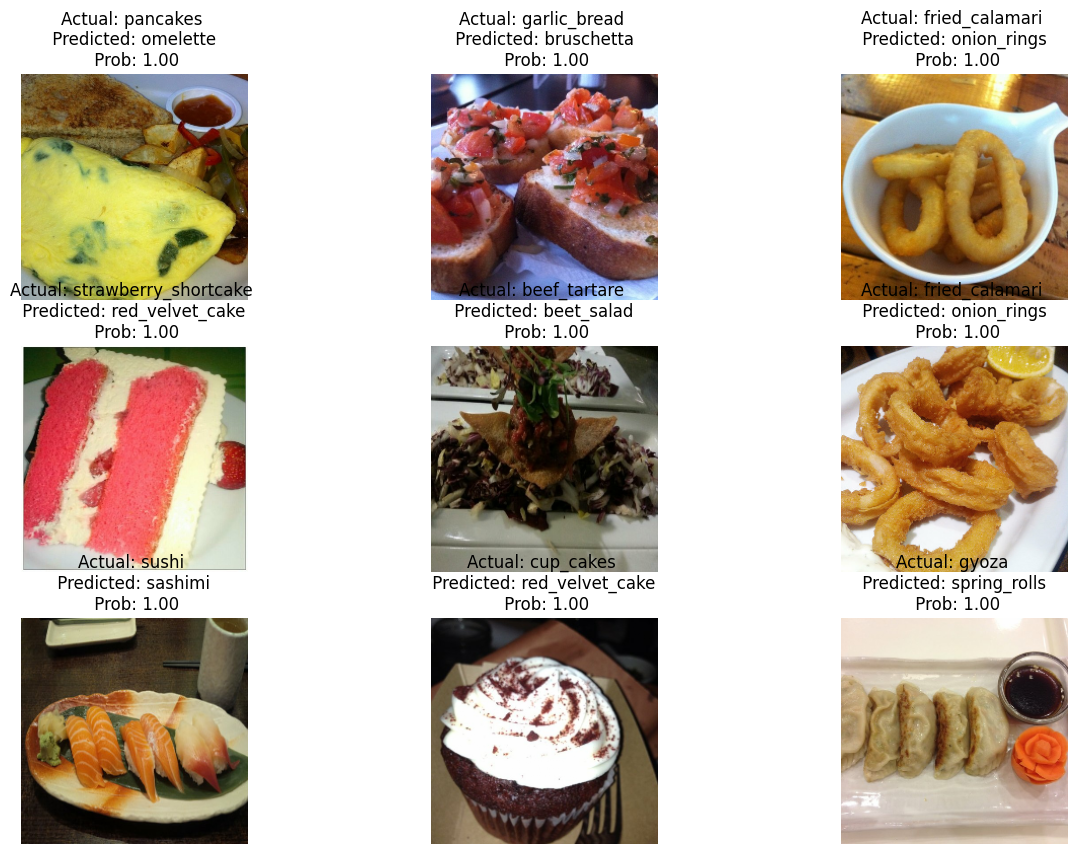

In [59]:
# Visualize the test data samples which have thehighest prediction confidence , but are wrong

images_to_view = 9
start_index = 10
plt.figure(figsize=(15, 10))
for i , row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row.img_path, scale = False)
    plt.imshow(img/255.)
    plt.title(f"Actual: {row.y_true_classname} \n Predicted: {row.y_pred_classname} \n Prob: {row.pred_conf:.2f}")
    plt.axis(False)
plt.show()


In [67]:
# Get custom food images filepath 

custom_food_images = ["/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/" + img_path for img_path in os.listdir("/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/")]
custom_food_images

['/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/ramen.jpeg',
 '/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/hamburger.jpeg',
 '/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/chicken_wings.jpeg',
 '/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/pizza-dad.jpeg',
 '/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/steak.jpeg',
 '/home/akhil/Documents/Tf_Local/custom_food_images/custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 27ms/step


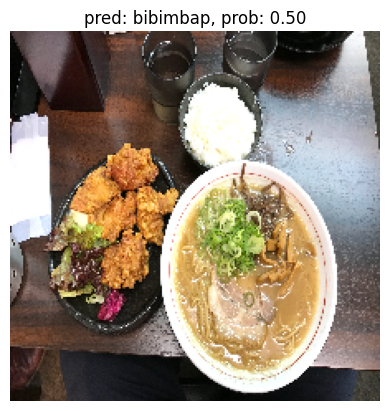

1/1 [==============================] - 0s 23ms/step


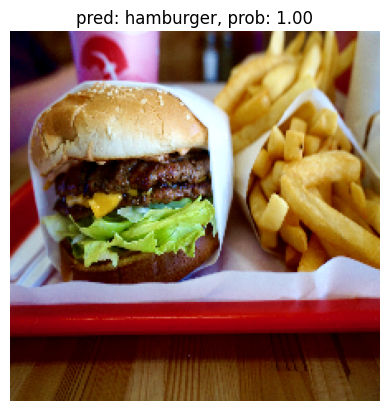

1/1 [==============================] - 0s 26ms/step


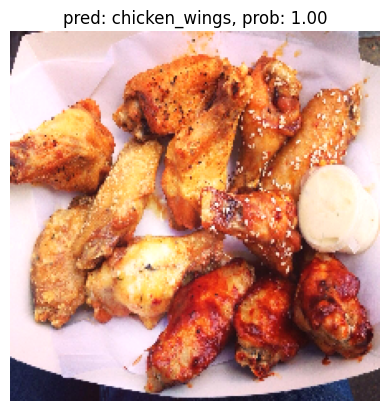

1/1 [==============================] - 0s 31ms/step


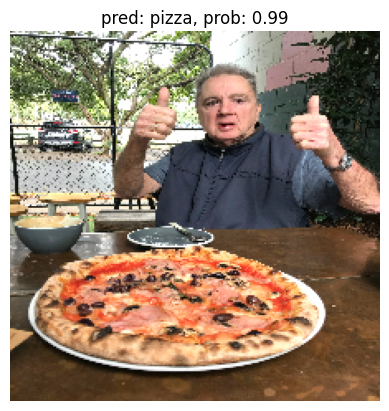

1/1 [==============================] - 0s 29ms/step


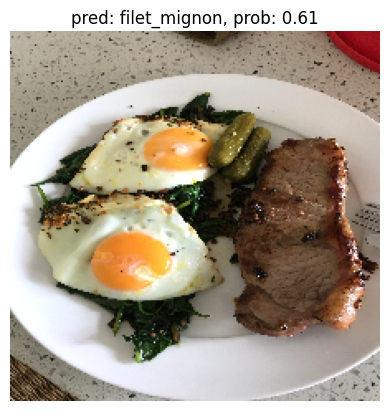

1/1 [==============================] - 0s 32ms/step


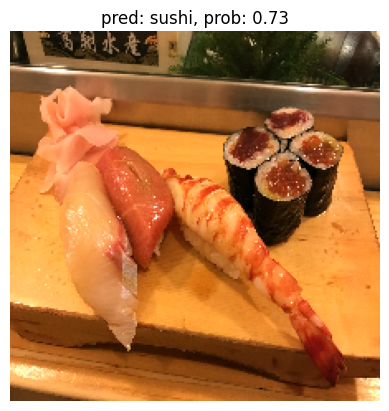

In [68]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3] (same shape as model was trained on)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highet prediction probability
  # Plot the appropriate information
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)
  plt.show()